<a href="https://www.kaggle.com/code/aleksandrmorozov123/machine-learning-excercises?scriptVersionId=93706992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Import required libraries**

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
    ensemble, 
    preprocessing, 
    tree,
)
from sklearn.metrics import (
auc,
confusion_matrix,
roc_auc_score,
roc_curve
)
from sklearn.model_selection import (
train_test_split,
)
from yellowbrick.classifier import (
ConfusionMatrix,
ROCAUC,
)
from yellowbrick.model_selection import (
LearningCurve,
)

**Read the data Titanic dataset**

In [2]:
df = pd.read_csv ('../input/titanic/train.csv')
orig_df = df

df.head (10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

**Cleaning the data**

In [3]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
import pandas_profiling
pandas_profiling.ProfileReport (df)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.shape

(891, 12)

In [6]:
df.describe ().iloc[:, :2]

PassengerId    Survived
count   891.000000  891.000000
mean    446.000000    0.383838
std     257.353842    0.486592
min       1.000000    0.000000
25%     223.500000    0.000000
50%     446.000000    0.000000
75%     668.500000    1.000000
max     891.000000    1.000000

In [7]:
df.isnull ().sum ()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [36]:
df.isnull ().sum (axis = 1).loc[:10]

0     1
1     0
2     1
3     0
4     1
5     2
6     0
7     1
8     1
9     1
10    0
dtype: int64

In [37]:
mask = df.isnull ().any (axis = 1)
mask.head ()  # rows

0     True
1    False
2     True
3    False
4     True
dtype: bool

In [38]:
df [mask].Embarked.head ()

0    S
2    S
4    S
5    Q
7    S
Name: Embarked, dtype: object

In [39]:
df.Sex.value_counts (dropna = False)

male      577
female    314
Name: Sex, dtype: int64

In [40]:
df.Embarked.value_counts (dropna = False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [41]:
name = df.Name
name.head (5)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [42]:
df = df.drop (
    columns=
    ["Name", 
     "Sex",
    "Age",
    "Ticket",
    "Fare",
    "Cabin",
    ]
)
df = pd.get_dummies (df)
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

**Sample data**

In [43]:
from sklearn.model_selection import train_test_split
y = df.Survived
X = df.drop (columns = 'Survived')

**Impute data**

In [44]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 42)

from sklearn.experimental import enable_iterative_imputer
from sklearn import impute
num_cols = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Embarked_C',
       'Embarked_Q', 'Embarked_S']

imputer = impute.IterativeImputer ()
imputed = imputer.fit_transform (
X_train [num_cols])
X_train.loc [:, num_cols] = imputed

meds = X_train.median ()
X_train = X_train.fillna (meds)
X_test = X_test.fillna (meds)

**Normalize data**

In [45]:
cols = "PassengerId, Name, Sex, Age, Ticket, Fare, Cabin".split (",")
sca = preprocessing.StandardScaler ()
X_train = sca.fit_transform (X_train)
X_train = pd.DataFrame (X_train, columns = cols)
X_test = sca.transform (X_test)
X_test = pd.DataFrame (X_test, columns = cols)

**Refactor**

In [46]:
from sklearn.model_selection import train_test_split
def tweak_titanic (df):
    df = df.drop (
    columns = [
        "PassengerId",
        "Name",
        "Sex",
        "Age",
        "Ticket",
        "Fare",
        "Cabin",
    ]
    ).pipe (pd.get_dummies, drop_first = True)
    return df

def get_train_test_X_y (
df, y_col, size = 0.3, std_cols = None
):
    y = df [y_col]
    X = df.drop (columns = y_col)
    X_train, X_test, y_train, y_test = train_test_split (
    X, y, test_size = size, random_state = 42
    )
    cols = X.columns
    num_cols = ['Pclass', 'SibSp', 'Parch',
    'Embarked_Q', 'Embarked_S']
    fi = impute.IterativeImputer ()
    X_train.loc [
        :, num_cols
    ] = fi.fit_transform (X_train [num_cols])
    X_test.loc [:, num_cols] = fi.transform (
    X_test [num_cols])
    
    if std_cols:
        std = preprocessing.StandardScaler ()
        X_train.loc [
            :, std_cols
        ] = std.fit_transform (
        X_train [std_cols])
        
        X_test.loc [
            :, std_cols
        ] = std.transform (X_test [std_cols])
        return X_train, X_test, y_train, y_test
    
ti_df = tweak_titanic (orig_df)
std_cols = "Pclass".split (",")
X_train, X_test, y_train, y_test = get_train_test_X_y (ti_df, "Survived", std_cols = std_cols)

**Baseline model**

In [47]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier ()
bm.fit (X_train, y_train)
bm.score (X_test, y_test) # accuracy

0.585820895522388

In [48]:
from sklearn import metrics
metrics.precision_score (y_test, bm.predict (X_test))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

**K-fold cross-validation**

In [59]:
X = pd.concat ([X_train, X_test])
y = pd.concat ([y_train, y_test])
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

for model in [
    DummyClassifier,
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier, 
    GaussianNB,
    SVC,
    RandomForestClassifier,
    ]:
    cls = model ()
    kfold = model_selection.KFold (n_splits=10, random_state=None)
    s = model_selection.cross_val_score (
    cls, X, y, scoring = 'roc_auc', cv = kfold)

    print (f"{model.__name__:22}   AUC: "
          f"{s.mean (): .3f} STD: {s.std(): .2f}")

DummyClassifier          AUC:  0.500 STD:  0.00
LogisticRegression       AUC:  0.717 STD:  0.05
DecisionTreeClassifier   AUC:  0.727 STD:  0.05
KNeighborsClassifier     AUC:  0.715 STD:  0.04
GaussianNB               AUC:  0.693 STD:  0.03
SVC                      AUC:  0.713 STD:  0.03
RandomForestClassifier   AUC:  0.735 STD:  0.05


**Staking**

In [60]:
from mlxtend.classifier import StackingClassifier
clfs = [
    x()
    for x in [
        LogisticRegression,
        DecisionTreeClassifier,
        GaussianNB,
        SVC,
        RandomForestClassifier
    ]
]
stack = StackingClassifier (classifiers=clfs,
                          meta_classifier = LogisticRegression ())
kfold = model_selection.KFold (n_splits = 10, random_state = None)

s = model_selection.cross_val_score (stack, X, y, scoring = 'roc_auc', cv = kfold)

print (f"{stack.__class__.__name__}  "
      f"AUC: {s.mean():.3f}  STD: {s.std():.2f}")

StackingClassifier  AUC: 0.686  STD: 0.04


**Create and evaluate Model**

In [61]:
# create model
rf = ensemble.RandomForestClassifier (n_estimators = 100, random_state = 42)
rf.fit (X_train, y_train)

# evaluate model
rf.score (X_test, y_test)

0.6940298507462687

In [62]:
# metrics precision
metrics.precision_score (y_test, rf.predict (X_test))

0.6790123456790124

In [63]:
# inspect feature performance
for col, val in sorted (zip (X_train.columns, rf.feature_importances_),
                       key = lambda x: x[1], reverse = True,
                       )[:5]:
    print (f"{col:10}{val:10.3f}")

Pclass         0.353
Parch          0.243
SibSp          0.238
Embarked_S     0.120
Embarked_Q     0.046


**Optimize model**

In [64]:
rf4 = ensemble.RandomForestClassifier ()
params = {
    "max_features": [0.4, "auto"],
    "n_estimators": [15, 200],
    "min_samples_leaf": [1, 0.1],
    "random_state": [42],
}
cv = model_selection.GridSearchCV (rf4, params, n_jobs=-1
                                  ).fit(X_train, y_train)
print (cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [65]:
rf5 = ensemble.RandomForestClassifier (
**{
    "max_features": "auto",
    "min_samples_leaf": 0.1,
    "n_estimators": 200,
    "random_state": 42,
})
rf5.fit (X_train, y_train)

rf5.score (X_test, y_test)

0.6492537313432836

**Confusion matrix**

In [66]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict (X_test)
confusion_matrix (y_test, y_pred)

array([[145,  12],
       [ 82,  29]])

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


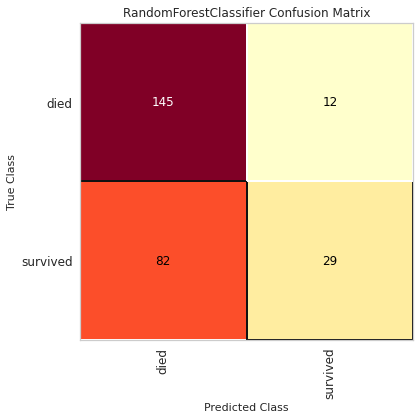

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [67]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots (figsize = (6, 6))
cm_viz = ConfusionMatrix (rf5, classes = ["died", "survived"],
                         label_encoder = mapping)
cm_viz.score (X_test, y_test)
cm_viz.poof ()

**ROC Curve**

In [68]:
y_pred = rf5.predict (X_test)
roc_auc_score (y_test, y_pred)

0.5924140701210765

/opt/conda/lib/python3.7/site-packages/yellowbrick/classifier/base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


AttributeError: 'RandomForestClassifier' object has no attribute 'target_type_'

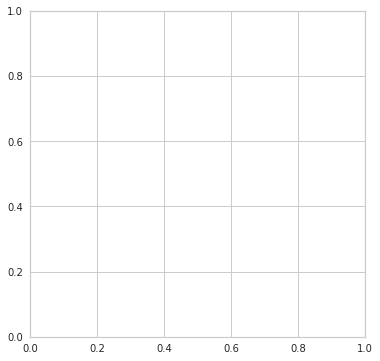

In [69]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
fig, ax = plt.subplots (figsize = (6, 6))
roc_viz = ROCAUC (rf5)
roc_viz.score (X_test, y_test)
roc_viz.poof ()

**Learning curve**

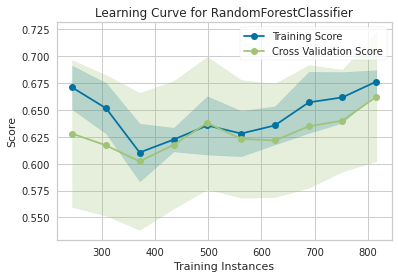

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [70]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

fig, ax = plt.subplots (figsize = (6, 4))
cv = StratifiedKFold (12)
sizes = np.linspace (0.3, 1.0, 10)
lc_viz = LearningCurve (
rf5, 
cv = cv,
train_sizes = sizes,
scoring = "f1_weighted",
n_jobs = 4,
ax = ax)

lc_viz.fit (X, y)
lc_viz.poof ()

**Deploing model**

In [71]:
import pickle
pic = pickle.dumps (rf5)
rf6 = pickle.loads (pic)
y_pred = rf6.predict (X_test)
roc_auc_score (y_test, y_pred)

0.5924140701210765

**Examining missing data**

In [8]:
df.isnull ().mean () * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

**Using missingno library**

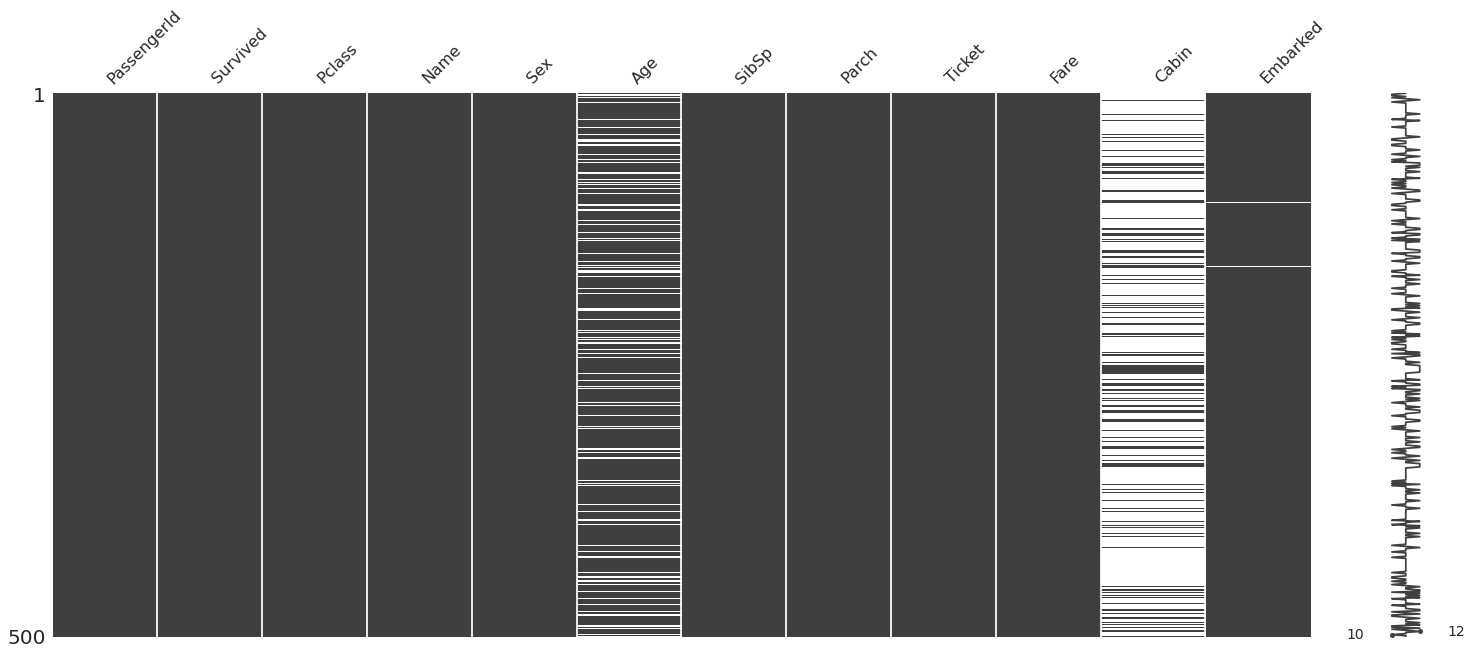

In [10]:
import missingno as msno
ax = msno.matrix (orig_df.sample (500))

**Bar plot**

TypeError: unsupported operand type(s) for -: 'int' and 'AxesSubplot'

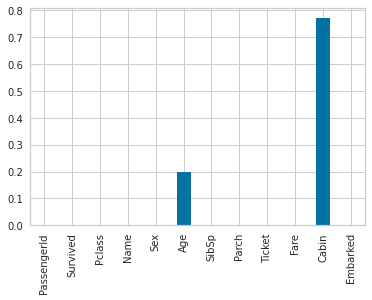

In [13]:
fig, ax = plt.subplots (figsize = (6, 4))
(1-df.isnull().mean().abs().plot.bar (ax=ax))

**Missingno library bar plot**

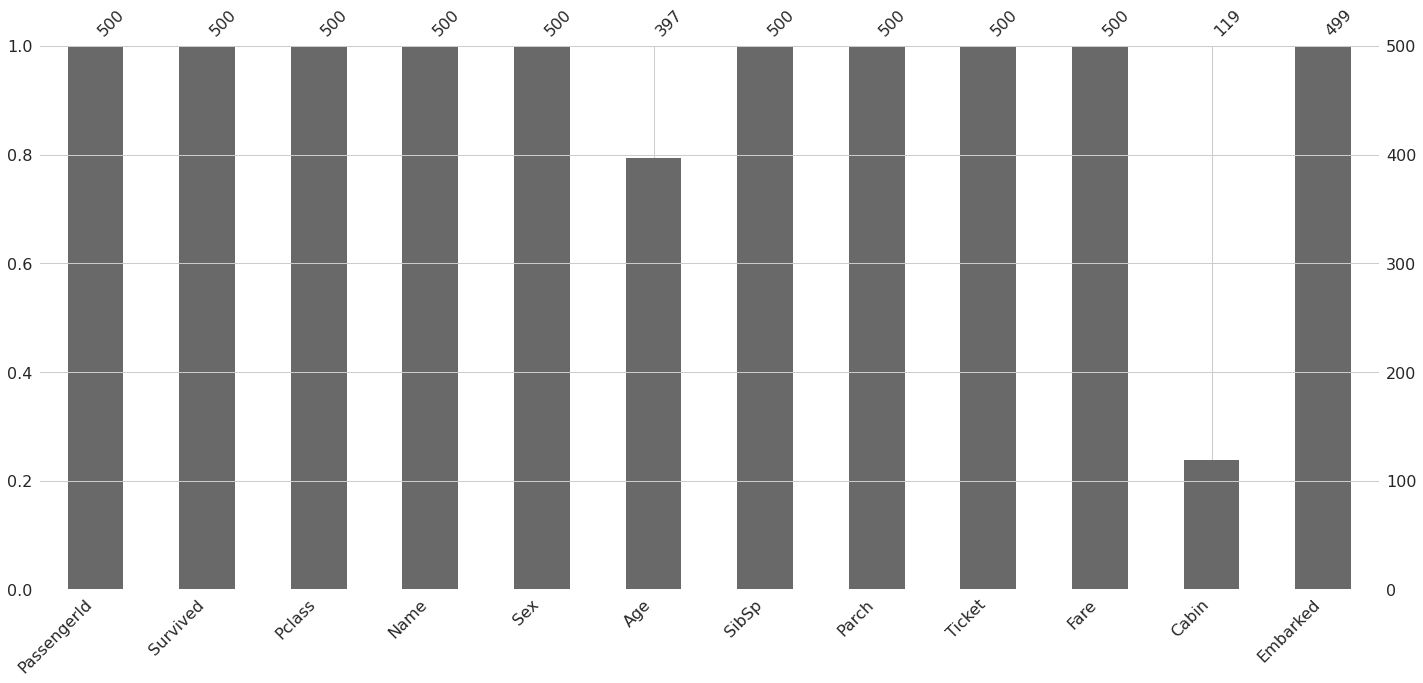

In [15]:
ax = msno.bar (orig_df.sample (500))

**Create a heatmap**

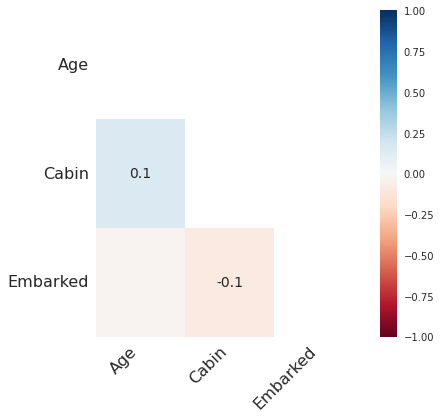

In [16]:
ax = msno.heatmap (df, figsize = (6, 6))

**Create a dendrogram**

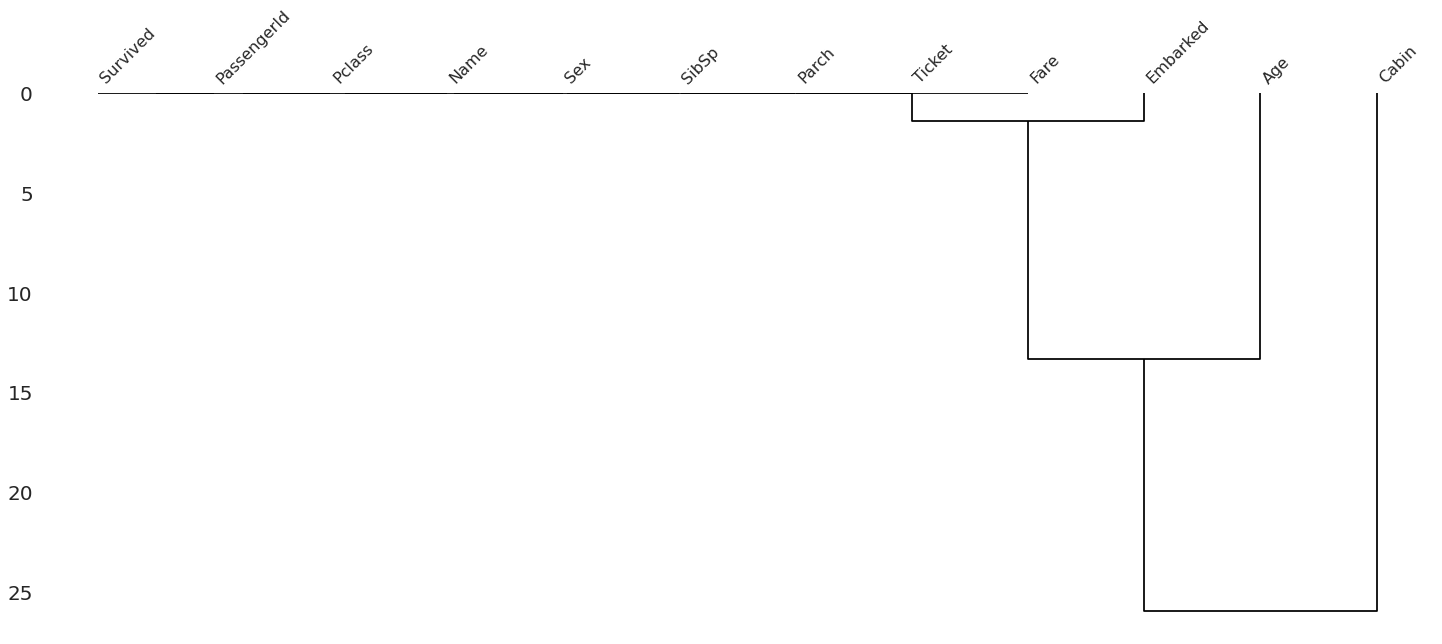

In [17]:
ax = msno.dendrogram (df)

**Dropping missnig data**

In [19]:
df1 = df.dropna ()
df1 = df.drop (columns = "Cabin")
df1 = df.dropna (axis = 1)

**Imputing data**

In [22]:
from sklearn.impute import SimpleImputer 
num_cols = df.select_dtypes (include = "number").columns
im = SimpleImputer ()  # mean
imputed = im.fit_transform (df[num_cols])

**Adding indicator columns**

In [23]:
def add_indicator (col):
    def wrapper (df):
        return df[col].isna().astype (int)
    
    return wrapper

df1 = df.assign (cabin_missing = add_indicator ("Cabin"))

**Exploring data**

In [49]:
X.shape 

(891, 7)

In [50]:
X.describe ().iloc [:, [0, -1]]

PassengerId  Embarked_S
count   891.000000  891.000000
mean    446.000000    0.722783
std     257.353842    0.447876
min       1.000000    0.000000
25%     223.500000    0.000000
50%     446.000000    1.000000
75%     668.500000    1.000000
max     891.000000    1.000000

In [51]:
X.iloc [[1, 2], -3]

1    1
2    0
Name: Embarked_C, dtype: uint8

In [54]:
X.loc [[677, 864], "Embarked_S":]

Embarked_S
677           1
864           1

**Hidtogram**

<AxesSubplot:ylabel='Frequency'>

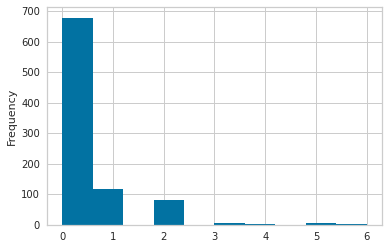

In [58]:
fig, ax = plt.subplots (figsize = (6, 4))
X.Parch.plot (kind ="hist", ax=ax)